<a href="https://colab.research.google.com/github/Arkaprabha1012/pythonopencv/blob/main/ResnetOnCovidpneunormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
!python --version

Python 3.7.10


In [ ]:
%tensorflow_version 2.1.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import tensorflow

print(tensorflow.__version__)

2.4.1


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arkaprabha1012","key":"f07b1a3ffd2b86f82a0788e5e9dc8dfe"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-07 10:21:15            107  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            110  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            229  
nickuzmenkov/ranzcr-clip-kfold-tfrecords                    RANZCR CLiP KFold TFRecords                         2GB  2021-02-21 13:29:51             11  
landrykezebou/lvzhdr-tone-mapping-benchmark-dataset-tmonet  LVZ-HDR Tone Map

In [1]:
#!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
#!wget https://www.dropbox.com/s/il6smb77d9m8hmi/Dataset.zip?dl=0
#!wget https://www.dropbox.com/s/9jl6axf8851185t/Original.zip?dl=0
#!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!wget https://www.dropbox.com/s/ocogoroxxds99mg/claheplussharpening.zip?dl=0

--2021-03-12 12:57:53--  https://www.dropbox.com/s/ocogoroxxds99mg/claheplussharpening.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ocogoroxxds99mg/claheplussharpening.zip [following]
--2021-03-12 12:57:53--  https://www.dropbox.com/s/raw/ocogoroxxds99mg/claheplussharpening.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc07a7d592eb842afcb34bdc32d9.dl.dropboxusercontent.com/cd/0/inline/BKjjhYweFcEZi1LijoxfhDQGh_Hq4CX7uu0L8hbtHS_PKeHBJ5-RiGBu_ROMyYANU5dzNLeSgzXT8AEwRX27ORT64SVoO8FDWp8ivj5WPV7kUfao8zbBulb24KdyS93X_fBCOGzmgYhGIsnpizZOFMNG/file# [following]
--2021-03-12 12:57:53--  https://uc07a7d592eb842afcb34bdc32d9.dl.dropboxusercontent.com/cd/0/inline/BKjjhYweFcEZi1LijoxfhDQGh_Hq4CX7uu0L8hbtHS_PKeHBJ5-R

In [2]:
#!unzip covid19-radiography-database.zip
#!unzip /content/Dataset.zip?dl=0
#!unzip /content/gdrive/MyDrive/ALLISI/claheplussharpening.zip
#!unzip /content/gdrive/MyDrive/DatasetOriginalupdated.zip
!unzip /content/claheplussharpening.zip?dl=0  

Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed/Normalsharp/NORMAL-1993.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2000.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2002.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2014.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2015.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2018.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2020.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2046.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2054.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2069.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2090.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2094.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2100.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2112.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2113.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2120.png  
  inflating: Preprocessed/Normalsharp/NORMAL-2124.png

In [3]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
pip install split-folders tqdm

In [5]:
!rmdir "/content/COVID-19_Radiography_Dataset/.ipynb_checkpoints/"
!rmdir "/content/COVID-19_Radiography_Dataset/.ipynb_checkpoints/"

rmdir: failed to remove '/content/COVID-19_Radiography_Dataset/.ipynb_checkpoints/': No such file or directory
rmdir: failed to remove '/content/COVID-19_Radiography_Dataset/.ipynb_checkpoints/': No such file or directory


In [6]:
#rm "/content/COVID-19RadiographyDatabase/.xlsx"
#!rmdir "/content/COVID-19RadiographyDatabase/.ipynb_checkpoints" active it when working with kaggle dataset

In [5]:
import splitfolders  # or import split_folders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.

splitfolders.ratio("/content/Preprocessed", output="Output", seed=1337, ratio=(.6,.2,.2), group_prefix=None) # default values
# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
splitfolders.fixed("/content/Preprocessed", output="Output", seed=1337, fixed=(70,70), oversample=False, group_prefix=None) # default values

Copying files: 21165 files [00:04, 4511.83 files/s]
Copying files: 21165 files [00:25, 816.56 files/s] 


In [7]:
'''from sklearn.model_selection import KFold
kf=KFold(n_splits=3)
print(kf)
for train_index,test_index in kf.split()'''

'from sklearn.model_selection import KFold\nkf=KFold(n_splits=3)\nprint(kf)\nfor train_index,test_index in kf.split()'

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
!zip -r /content/gdrive/MyDrive/ALLISI/Dataset602020splitclahesharpening.zip /content/Output
#!unzip /content/gdrive/MyDrive/Preprocessed.zip

Streaming output truncated to the last 5000 lines.
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-1526.png (deflated 1%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-1156.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-5341.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-2713.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-4465.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-606.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-2737.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-4568.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-5972.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-2414.png (deflated 0%)
  adding: content/Output/train/Lung_opacitysharp/Lung_Opacity-5597.png (deflated 0%)
  adding: conte

In [ ]:
#from google.colab import files
#files.download("/content/folder.zip")

In [6]:
img_height,img_width=(224,224)
batch_size=128
train_data_dir="/content/Output/train"
valid_data_dir="/content/Output/val"
!rmdir "/content/Output/train/.ipynb_checkpoints/"
!rmdir "/content/Output/val/.ipynb_checkpoints/"
test_data_dir="/content/Output/test"

rmdir: failed to remove '/content/Output/train/.ipynb_checkpoints/': No such file or directory
rmdir: failed to remove '/content/Output/val/.ipynb_checkpoints/': No such file or directory


In [7]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 validation_split=0.4)
train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='training')
valid_generator=train_datagen.flow_from_directory(valid_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='validation')
test_generator=train_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  subset='validation')

print(valid_generator.class_indices)
print(train_generator.class_indices)
print(test_generator.class_indices)

Found 12365 images belonging to 4 classes.
Found 1803 images belonging to 4 classes.
Found 1692 images belonging to 4 classes.
{'COVIDsharp': 0, 'Lung_opacitysharp': 1, 'Normalsharp': 2, 'Viral_Pneumoniasharp': 3}
{'COVIDsharp': 0, 'Lung_opacitysharp': 1, 'Normalsharp': 2, 'Viral_Pneumoniasharp': 3}
{'COVIDsharp': 0, 'Lung_opacitysharp': 1, 'Normalsharp': 2, 'Viral_Pneumoniasharp': 3}


In [8]:
base_model=ResNet50(include_top=False,
                    weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers:
  layer.trainable=False
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
from keras.callbacks import ModelCheckpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint=ModelCheckpoint(filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list=[checkpoint]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
15/15 [==============================] - 71s 2s/step - loss: 4.2340 - accuracy: 0.4220 - val_loss: 1.1834 - val_accuracy: 0.6931

Epoch 00001: val_accuracy improved from -inf to 0.69308, saving model to weights-improvement-01-0.69.hdf5
Epoch 2/100
15/15 [==============================] - 35s 2s/step - loss: 1.0666 - accuracy: 0.6905 - val_loss: 0.6585 - val_accuracy: 0.7344

Epoch 00002: val_accuracy improved from 0.69308 to 0.73438, saving model to weights-improvement-02-0.73.hdf5
Epoch 3/100
15/15 [==============================] - 35s 2s/step - loss: 0.6284 - accuracy: 0.7589 - val_loss: 0.5613 - val_accuracy: 0.7768

Epoch 00003: val_accuracy improved from 0.73438 to 0.77679, saving model to weights-improvement-03-0.78.hdf5
Epoch 4/100
15/15 [==============================] - 35s 2s/step - loss: 0.5970 - accuracy: 0.7705 - val_loss: 0.5333 - val_accuracy: 0.7969

Epoch 00004: val_accuracy improved from 0.77679 to 0.79688, saving model to weights-improvement-04-0.80.hdf5

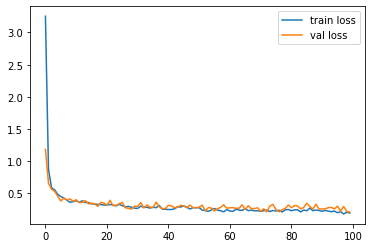

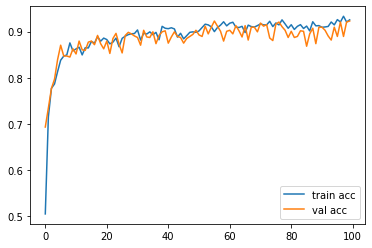

<Figure size 432x288 with 0 Axes>

In [10]:
'''r = model.fit_generator(
  train_generator,
  epochs=10,
  steps_per_epoch=len(valid_generator),
  validation_data=valid_generator,
  validation_steps=len(valid_generator),
  callbacks=callbacks_list
)'''
r = model.fit_generator(
  train_generator,
  epochs=100,
  steps_per_epoch=len(valid_generator),
  validation_data=valid_generator,
  validation_steps=2000//(batch_size*2),
  callbacks=callbacks_list
)
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [14]:
model.save("6020clahesharpen.h5")

In [16]:
'''#To load a new model
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/MyDrive/resenet50kaggleupdated.h5')'''

"#To load a new model\nfrom tensorflow import keras\nmodel = keras.models.load_model('/content/gdrive/MyDrive/resenet50kaggleupdated.h5')"

In [17]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2)
print("Test accuracy:",test_acc)
print("Test Loss:",test_loss)

14/14 - 20s - loss: 0.2361 - accuracy: 0.9167
Test accuracy: 0.9166666865348816
Test Loss: 0.23607821762561798


In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import keras
from tensorflow.keras import utils
# We need not to create and train the model again
# No need to train the model, its a pre defined trained model
model = load_model("/content/resenet50medicaloriginal97percent656.h5")
#model.compile(optimizer='adam', loss='b_crossentropy', metrics=['accuracy'])

# Testing the Normal Image
image = cv2.imread("/content/wong-0005.jpg")
# image = cv2.imread("covid19dataset/test/covid/nejmoa2001191_f3-PA.jpeg")    # 0
image = cv2.resize(image, (128, 128))
image = np.reshape(image, [1, 128, 128, 3])
classes = model.predict(image)
result=np.argmax(classes)
if result==0:
  print("COVID")
elif result==1:
  print("NORMAL")
else:
  print("PNEUMONIA")

COVID


In [15]:
import shutil
shutil.move("/content/6020clahesharpen.h5", "/content/gdrive/MyDrive/ALLISI")

'/content/gdrive/MyDrive/ALLISI/6020clahesharpen.h5'

In [ ]:
pip install pillow01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg

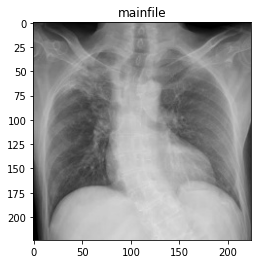

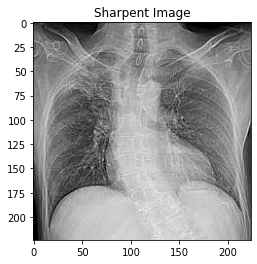

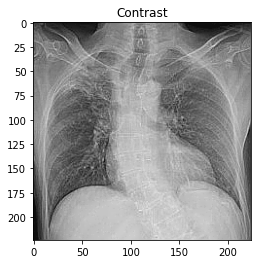

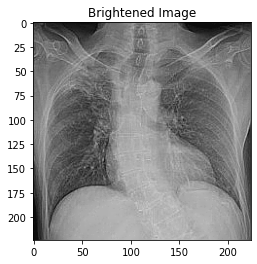

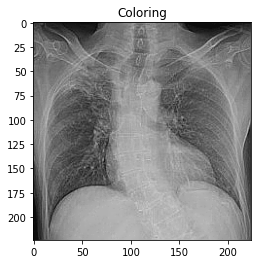

In [ ]:
#IMAGE ENHANCEMENT
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance
filename="/content/000012-3.jpg"
image=Image.open(filename)
plt.title("mainfile")
plt.imshow(image,'gray')
plt.show()
size=width,height=image.size
enhancer=ImageEnhance.Sharpness(image)
image=enhancer.enhance(7.0)
plt.title("Sharpent Image")
plt.imshow(image,'gray')
plt.show()
enhancer=ImageEnhance.Contrast(image)
image=enhancer.enhance(0.9)
plt.title("Contrast")
plt.imshow(image,'gray')
plt.show()
enhancer=ImageEnhance.Brightness(image)
image=enhancer.enhance(0.9)
plt.title("Brightened Image")
plt.imshow(image,'gray')
plt.show()
enhancer=ImageEnhance.Color(image)
image=enhancer.enhance(0.9)
plt.title("Coloring")
plt.imshow(image,'gray')
plt.show()

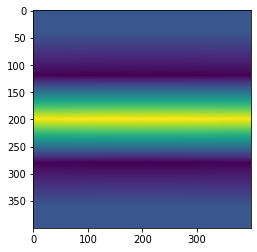

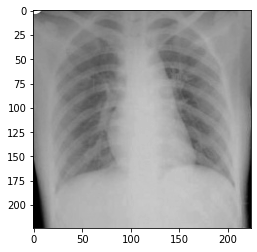

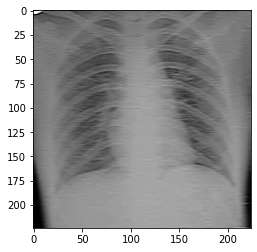

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

ksize = 5  #Use size that makes sense to the image and fetaure size. Large may not be good. 
#On the synthetic image it is clear how ksize affects imgae (try 5 and 50)
sigma = 1 #Large sigma on small features will fully miss the features. 
theta = 1*np.pi/2  #/4 shows horizontal 3/4 shows other horizontal. Try other contributions
lamda = 1*np.pi /2  #1/4 works best for angled. 
gamma=0.1  #Value of 1 defines spherical. Calue close to 0 has high aspect ratio
#Value of 1, spherical may not be ideal as it picks up features from other regions.
phi = 0  #Phase offset. I leave it to 0. 


kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

plt.imshow(kernel)


img = cv2.imread('/content/gr1_lrg-b.jpg')
#img = cv2.imread('BSE_Image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

kernel_resized = cv2.resize(kernel, (400, 400))                    # Resize image
plt.imshow(kernel_resized)
plt.show()
plt.imshow(img,'gray')
plt.show()
plt.imshow(fimg,'gray')
plt.show()